# 非負値行列分解（NMF）の実装

## １．irisデータに適用してみて，PCAとの比較

### 参考にしたサイト
### https://www.haya-programming.com/entry/2019/05/14/204835

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, NMF
from sklearn.datasets import load_iris

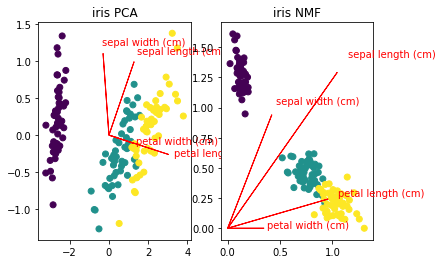

In [2]:
 iris = load_iris()

pca = PCA(n_components=2)
nmf = NMF(n_components=2)

fig, axes = plt.subplots(nrows=1, ncols=2)

for i, mname, method in zip([0,1], ["PCA", "NMF"], [pca, nmf]):
    X_2d = method.fit_transform(iris.data)

    # title
    axes[i].set_title("{} {}".format("iris", mname))

    # scatter
    axes[i].scatter(X_2d[:,0], X_2d[:,1], c=iris.target)

    # arrows
    pc0 = method.components_[0]
    pc1 = method.components_[1]

    pc0 = pc0 * (np.abs(X_2d[:,0]).max() / np.abs(pc0).max()) * 0.8 
    pc1 = pc1 * (np.abs(X_2d[:,1]).max() / np.abs(pc1).max()) * 0.8

    for j in range(pc0.shape[0]):
        axes[i].arrow(
            0, 0, pc0[j], pc1[j], color='r')
        axes[i].text(
            pc0[j]*1.1, pc1[j]*1.1, iris.feature_names[j], color='r')

plt.show()

### コメント
### ・NMFは全て非負となるのが特徴であり，疎な結果が得られやすく解釈がしやすそう（petal widthが0となっている，今回のデータでは正直あまりメリットはない）
### ・PCAではpetal withとpetal lengthが重なっているので，その点でも解釈しやすいといえる

## ２．顔画像のデータに適用

### 参考にしたサイト
### https://www.letitride.jp/entry/2020/07/26/145649

### NMFの特徴を確認
####  ・NMFは全てのベクトルが正となり，直交しないことが特徴

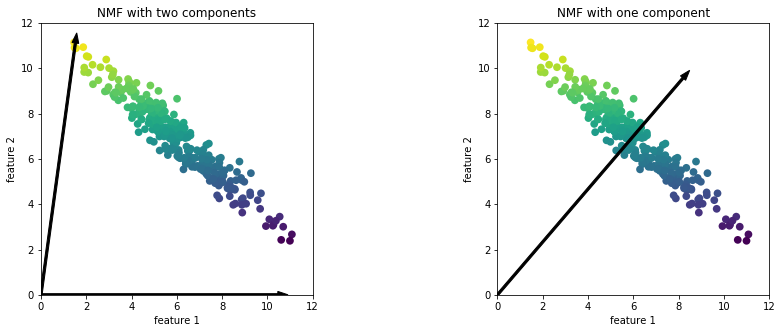

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
import mglearn

mglearn.plots.plot_nmf_illustration()

### 使用データ：sklearn.datasets.fetch_lfw_people
### データの確認
### ・data :画像数は1140個。1画像は8742（ 縦62×横47×RGB3）
### ・imges :画像形式の配列
### ・target :分類結果（dataを分類した場合の正解データになる値）
### ・target_name : 分類結果（target）の値に対応する人物名（文字列）

In [4]:
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
# reshapeする時の画像解像度に応じた行列
print(people.keys())
print(people.data.shape)
print(people.images.shape)
print(people.target)
print(people.target_names)

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])
(3023, 5655)
(3023, 87, 65)
[61 25  9 ... 14 15 14]
['Alejandro Toledo' 'Alvaro Uribe' 'Amelie Mauresmo' 'Andre Agassi'
 'Angelina Jolie' 'Ariel Sharon' 'Arnold Schwarzenegger'
 'Atal Bihari Vajpayee' 'Bill Clinton' 'Carlos Menem' 'Colin Powell'
 'David Beckham' 'Donald Rumsfeld' 'George Robertson' 'George W Bush'
 'Gerhard Schroeder' 'Gloria Macapagal Arroyo' 'Gray Davis'
 'Guillermo Coria' 'Hamid Karzai' 'Hans Blix' 'Hugo Chavez' 'Igor Ivanov'
 'Jack Straw' 'Jacques Chirac' 'Jean Chretien' 'Jennifer Aniston'
 'Jennifer Capriati' 'Jennifer Lopez' 'Jeremy Greenstock' 'Jiang Zemin'
 'John Ashcroft' 'John Negroponte' 'Jose Maria Aznar'
 'Juan Carlos Ferrero' 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush'
 'Lindsay Davenport' 'Lleyton Hewitt' 'Luiz Inacio Lula da Silva'
 'Mahmoud Abbas' 'Megawati Sukarnoputri' 'Michael Bloomberg' 'Naomi Watts'
 'Nestor Kirchner' 'Paul Bremer' 'Pete Sampras' 'Recep Tayyip Erdogan'
 'Ricardo La

### 最初の画像3つを表示してみる

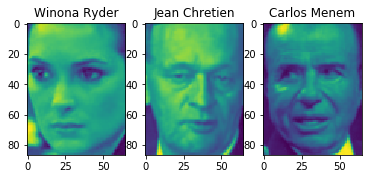

In [5]:
from matplotlib import pyplot as plt

plt.subplots_adjust(wspace=0.2, hspace=0.6)

for i in range(3):
    subplt = plt.subplot(1,3, i+1)
    subplt.imshow(people.images[i]/255) # RGBデータ表示の場合、floatは[0 - 1]でclipされるので、[0 - 1]に正規化して表示する
    subplt.set_title(people.target_names[people.target[i]])

plt.savefig('.\people_color.jpg')    
plt.show()

### NMFを適用してみる

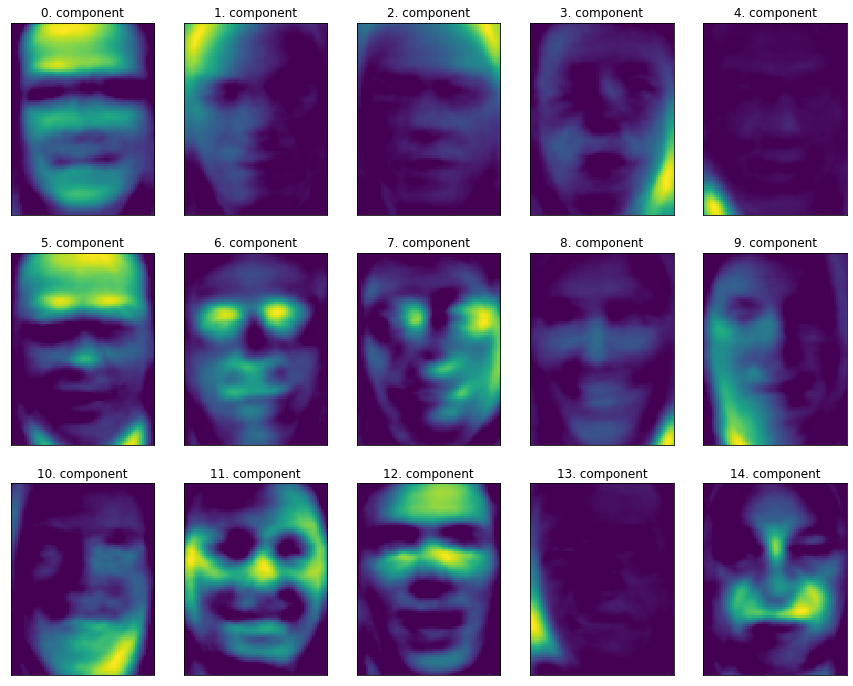

In [6]:
# reshapeする時の画像解像度に応じた行列
image_shape = people.images[0].shape

# 1人物50枚までにする為の処理。使用するindexにTrueを立てる、
# targetの数分のarrayを用意
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    # 各ターゲットの50件までTrueを立てる whereで条件に合うpeopleのindexを取得できる
    mask[np.where(people.target == target)[0][:50]] = 1

# Trueのデータのみ訓練、検証データに使用する
X_people = people.data[mask]
y_people = people.target[mask]

X_people = X_people / 255.

X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0
)

# NMF分解の実行 15個の特徴量に分解
nmf = NMF(n_components=15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)

fix, axes = plt.subplots(3,5,figsize=(15,12), subplot_kw={"xticks":(), "yticks":()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}. component".format(i))

### 成分ごとに確認

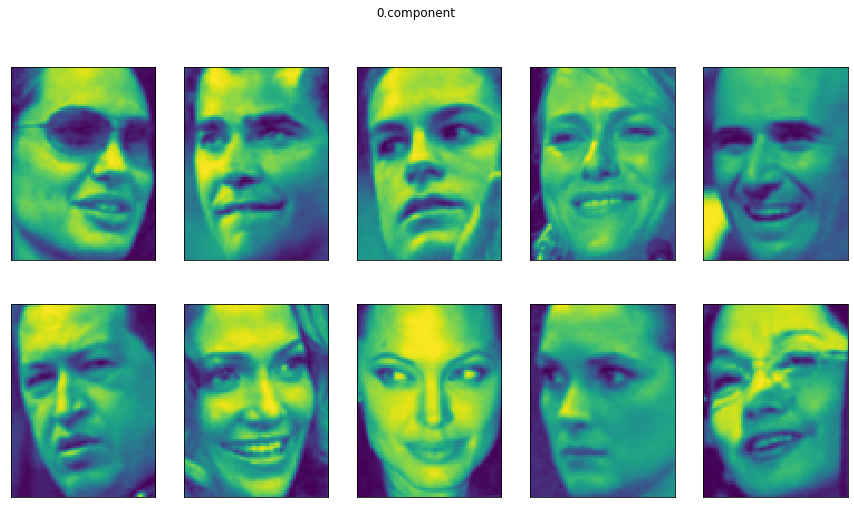

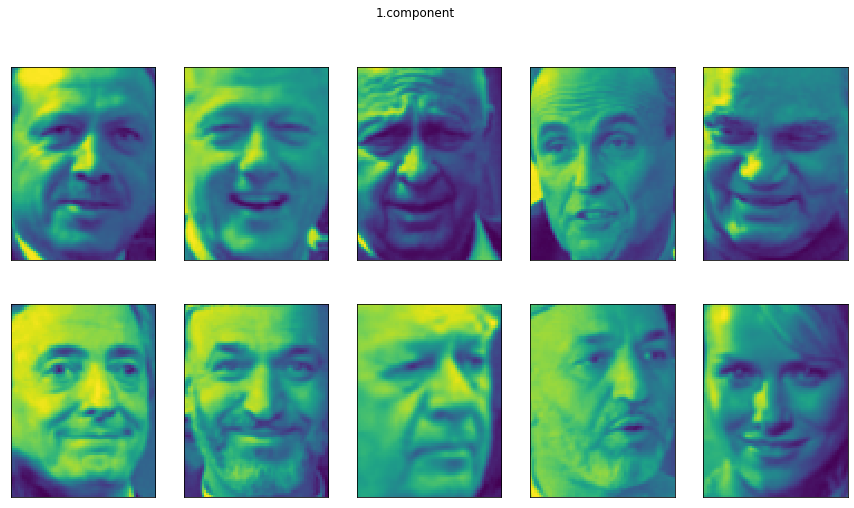

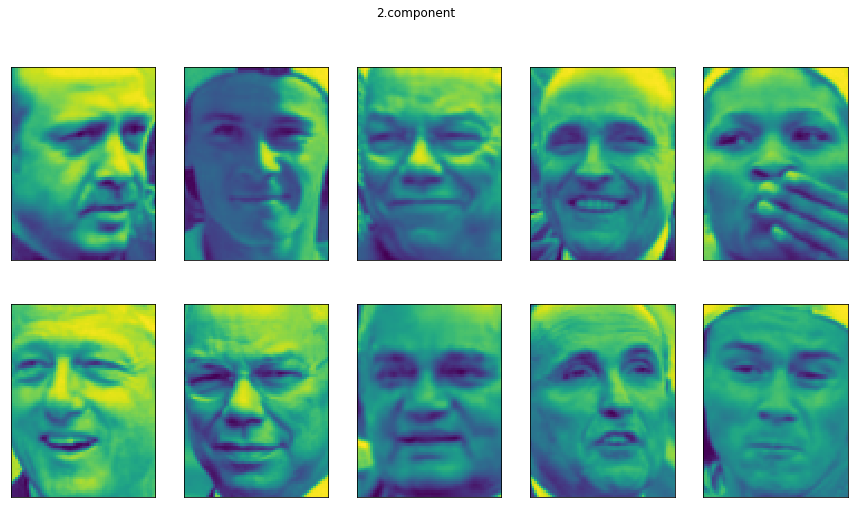

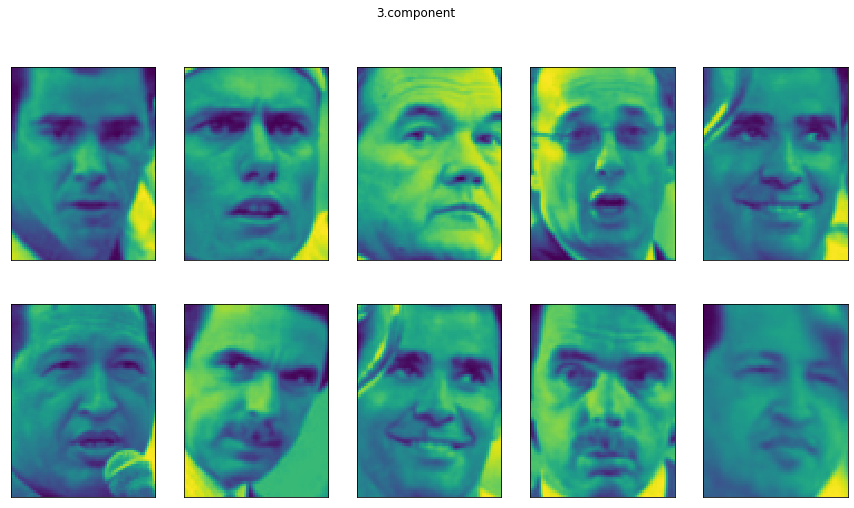

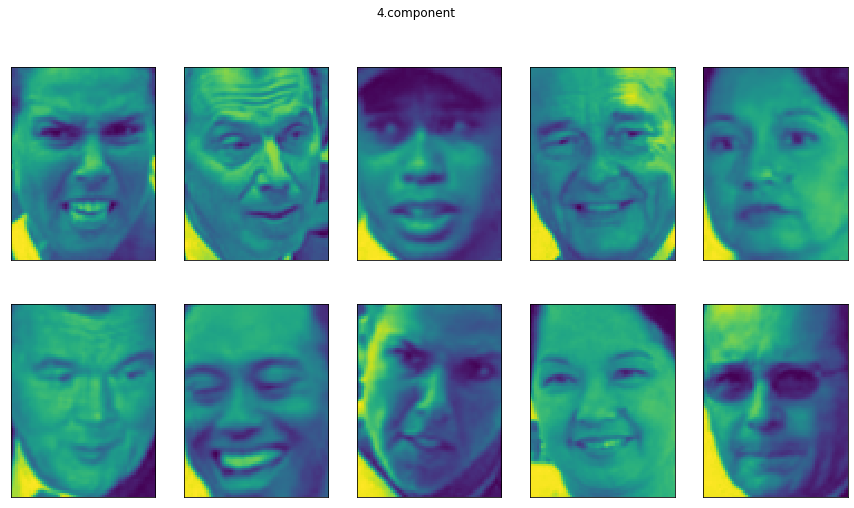

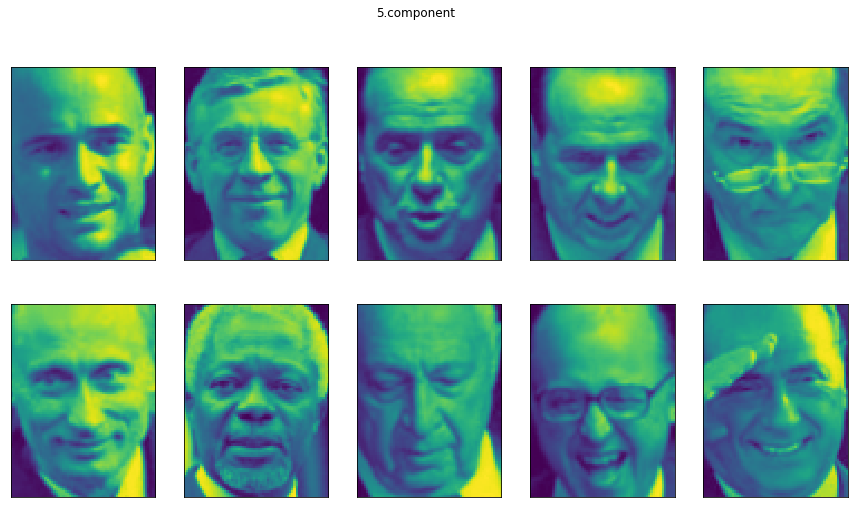

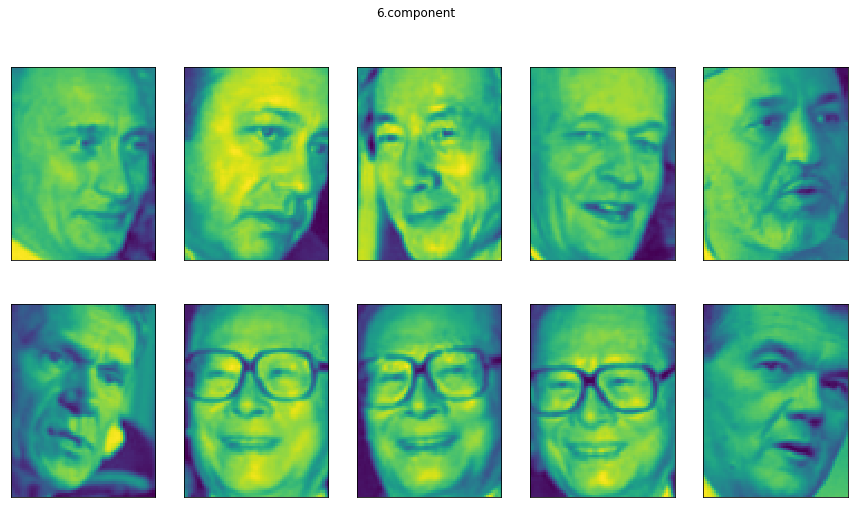

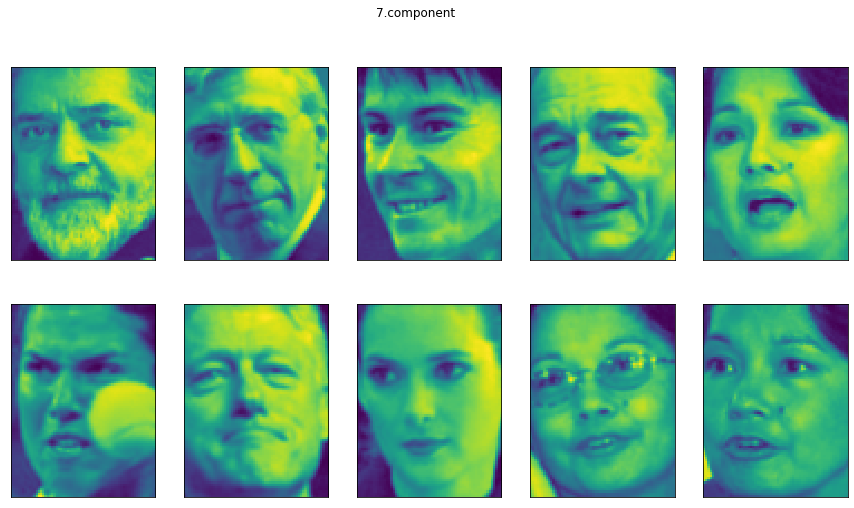

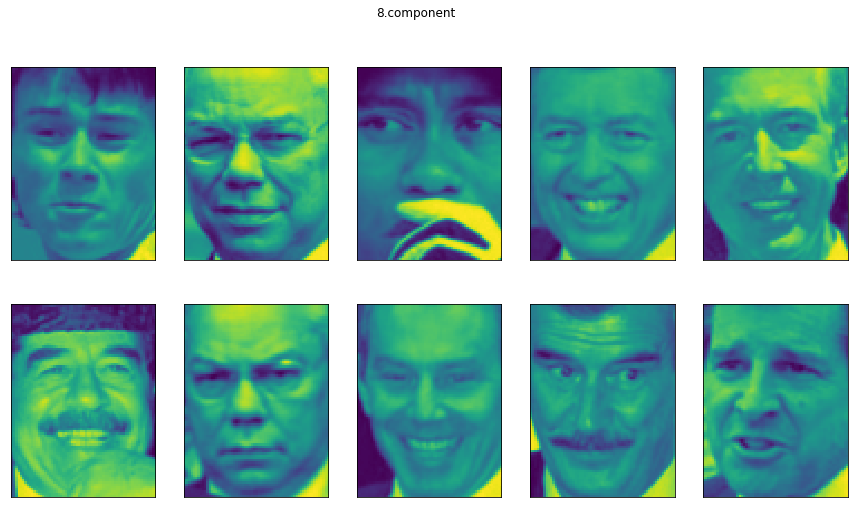

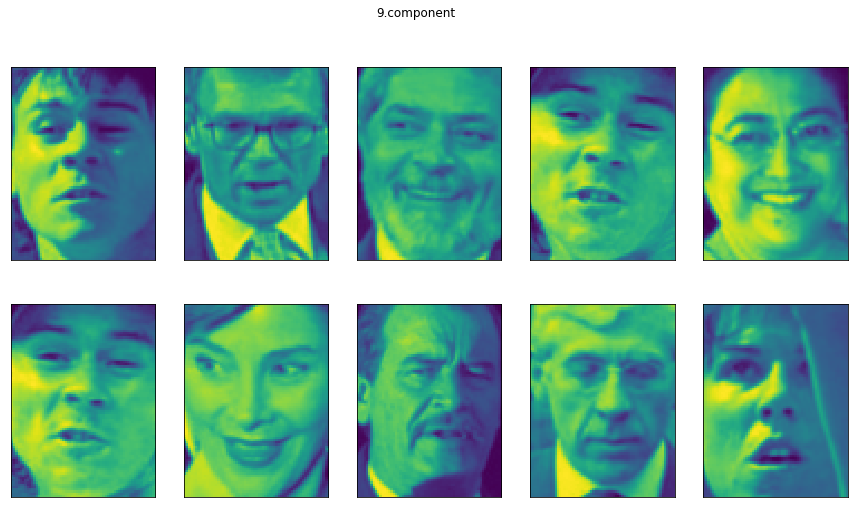

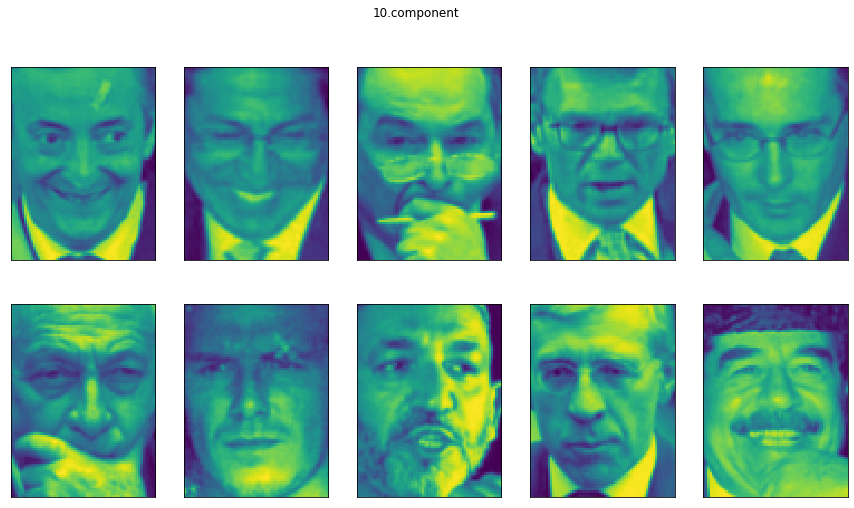

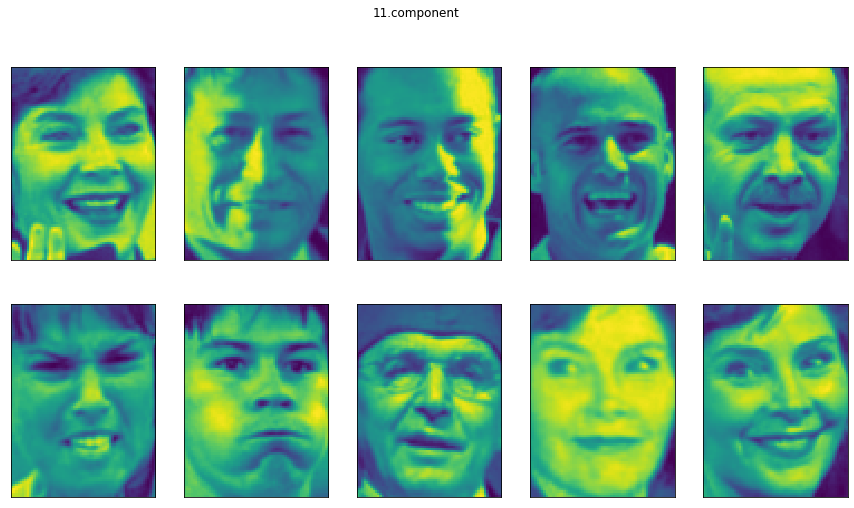

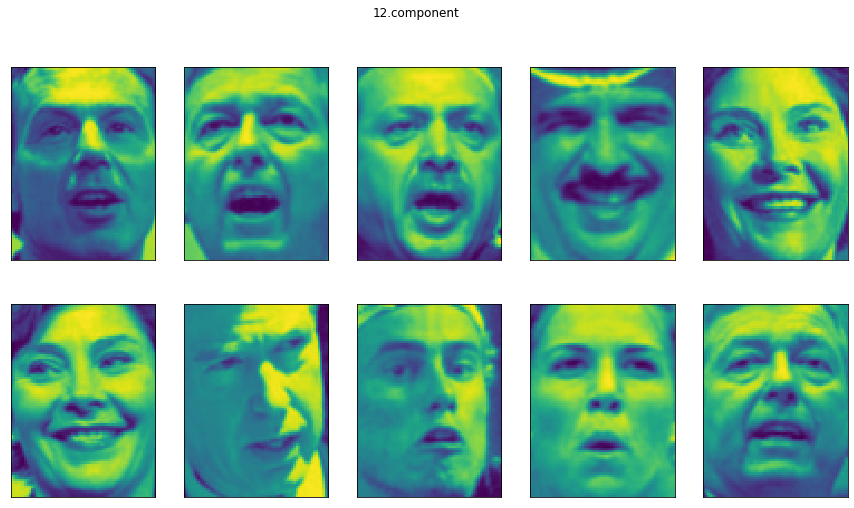

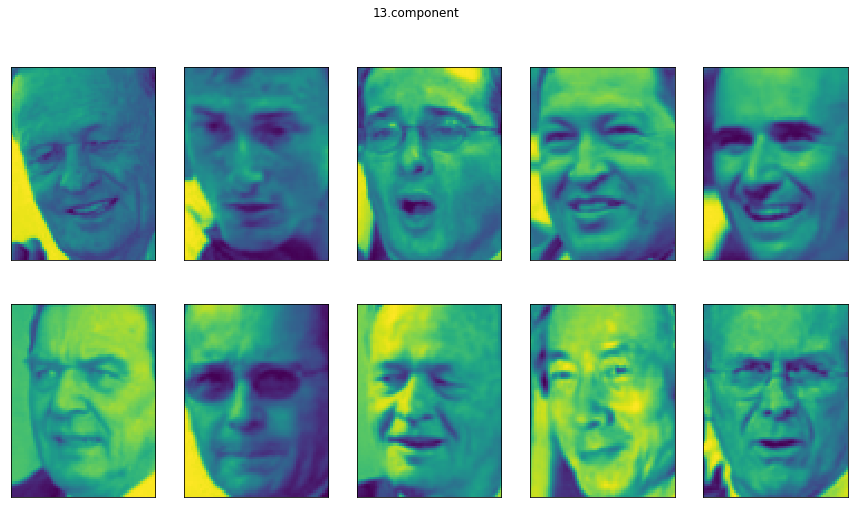

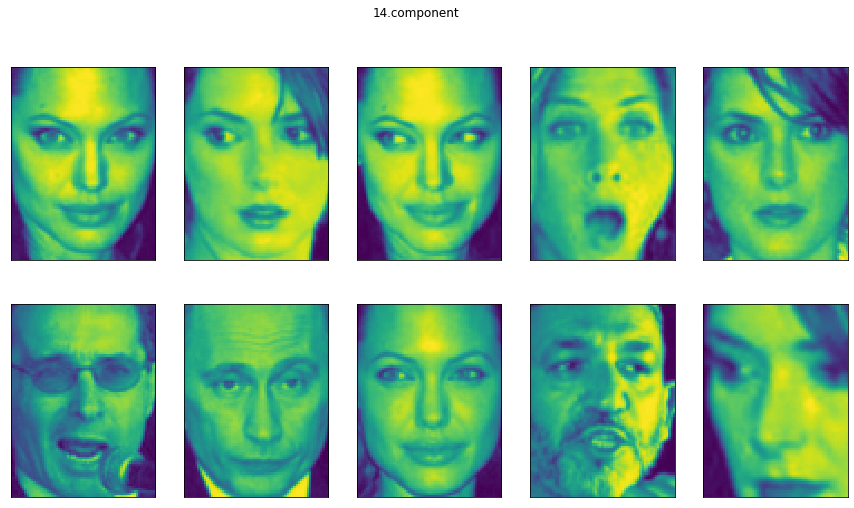

In [7]:
for compn in range(15):
    # 3つ目の成分でソート、
    inds = np.argsort(X_train_nmf[:, compn])[::-1]
    fig, axes = plt.subplots(2,5,figsize=(15,8),subplot_kw={"xticks":(), "yticks":()})
    fig.suptitle(str(compn) + '.component')
    for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
        ax.imshow(X_train[ind].reshape(image_shape))
        
plt.savefig("result.png")